In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pytensor import shared
from scipy import stats

from helpers.pandas import standardize
from helpers.paths import get_data_path

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [3]:
data = pd.read_csv(get_data_path("WaffleDivorce.csv"), delimiter=";")
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


### Figure 5.1


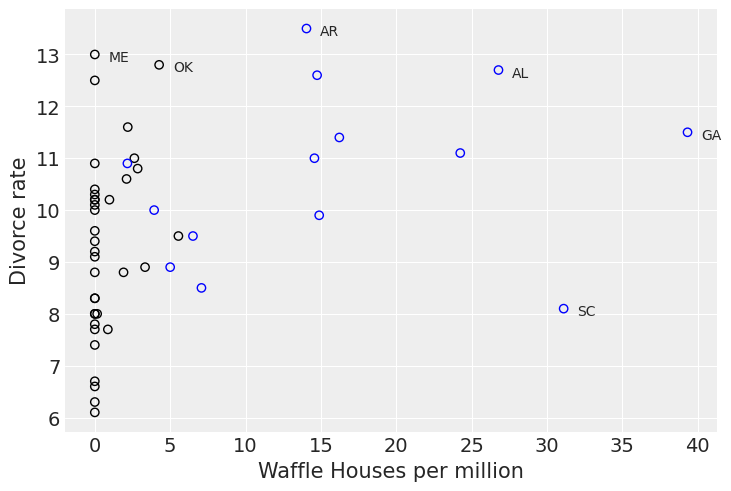

In [4]:
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[
    (data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)
]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(
        f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5)
    )

### Code 5.1


In [5]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [6]:
with pm.Model() as m5_3:
    A = data["MedianAgeMarriage"]
    M = data["Marriage"]
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    mu = alpha + bM * M + bA * A
    sigma = pm.Exponential("sigma", 1)
    pm.Normal("M", mu=mu, sigma=sigma)

    map_estimate = pm.find_MAP()
    trace = pm.sample(draws=2000, tune=1000)

Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bM, sigma, M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
There were 4527 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.060,0.160,-0.245,0.347,0.043,0.023,14.0,154.0,1.27
bA,0.095,0.403,-0.761,0.948,0.098,0.074,16.0,47.0,1.48
bM,-0.122,0.490,-0.797,0.671,0.194,0.066,8.0,30.0,1.72
M[0],-0.100,12.853,-24.525,27.801,3.349,2.896,13.0,46.0,1.65
M[1],-0.873,14.809,-28.434,29.450,4.317,2.924,11.0,43.0,1.59
M[2],-0.081,13.041,-23.981,28.984,3.392,2.936,12.0,47.0,1.66
M[3],-0.931,14.742,-27.504,29.001,4.395,2.793,11.0,41.0,1.58
M[4],0.204,12.989,-24.564,29.269,3.213,3.054,13.0,46.0,1.63
M[5],-0.406,13.964,-26.940,28.623,3.861,2.945,12.0,46.0,1.61
M[6],0.503,12.669,-26.245,28.501,2.941,3.076,15.0,45.0,1.68


### Code 5.10


In [8]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a
        + bM * data["Marriage_std"].values
        + bA * data["MedianAgeMarriage_std"].values,
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## 5.1.5.1 Predictor Residual Plot

"The benefit of computing these things is that, once plotted against the outcome, we have a bivariate regression that has already conditioned on all of the other predictor variables. It leaves the variation that is not expected by the model of the mean, µ, as a function of the other predictors."


### Code 5.13


In [9]:
data.columns

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860', 'Divorce_std',
       'Marriage_std', 'MedianAgeMarriage_std'],
      dtype='object')

In [10]:
with pm.Model() as m5_4:
    a = pm.Normal("a", mu=0, sigma=0.2)
    bAM = pm.Normal("bAM", mu=0, sigma=0.5)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)
    sigma = pm.Exponential("sigma", 1)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    priors = pm.sample_prior_predictive()
    m5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Code 5.14


"When a residual is positive, that means that the observed rate was in excess of what the model expects, given the median age at marriage in that State. When a residual is negative, that means the observed rate was below what the model expects."


In [11]:
mu_m5_4_mean = m5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m5_4_mean

residuals

0    -0.398480
1     1.072979
2    -0.093658
3     0.677015
4     0.147361
5     0.693213
6     0.066342
7     1.089177
8     1.393988
9    -0.628369
10    0.435985
11    1.730217
12   -0.093648
13   -0.057206
14   -0.281008
15   -0.000488
16   -0.065300
17   -0.150366
18    0.041031
19   -1.549929
20    0.215210
21    0.225333
22   -0.760020
23   -1.131682
24   -0.356961
25   -0.652670
26   -0.623302
27   -0.500764
28   -0.484566
29   -0.483557
30   -0.067328
31    0.432937
32   -0.123026
33    1.312989
34   -0.710397
35    0.048126
36   -0.350886
37   -0.633435
38   -0.152405
39   -0.338735
40   -0.257716
41   -0.664821
42   -0.111885
43    0.962602
44   -0.507859
45    0.293192
46    0.251673
47   -0.038969
48   -0.631406
49    1.753520
Name: Marriage_std, dtype: float64

## 5.1.5.2 Posterior Prediction


### Code 5.15


In [12]:
# Use model m_5_3 and adjust
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(
        m_5_3_trace, var_names=["mu", "divorce_rate_std"]
    )

# Summarize samples across cases
mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

# Simulate observations
D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


Output()

"This code is similar to what you’ve seen before, but now using the original observed data. For multivariate models, there are many difefrent ways to display these simulations. **The simplest is to just plot predictions against observed.**"


### Code 5.16, 5.17


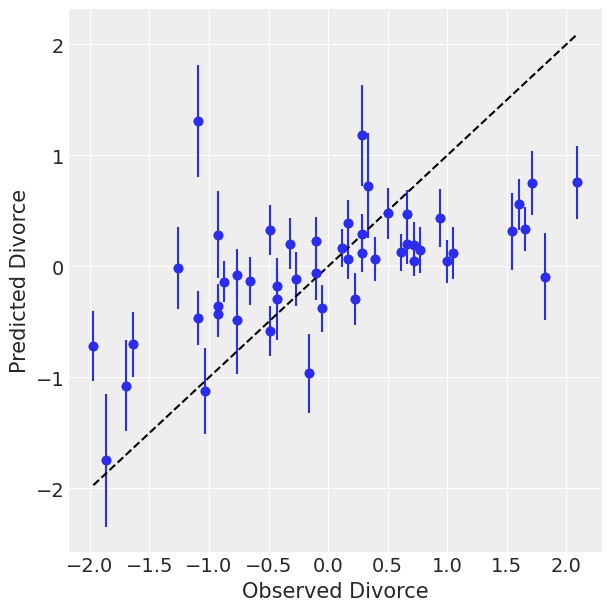

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

### Code 5.18

"One way that spurious associations between a predictor and outcome can arise is when a truly causal predictor, call it xreal, infulences both the outcome, y, and a spurious predictor, xspur. This can be confusing, however, so it may help to simulate this scenario and see both how the spurious data arise and prove to yourself that multiple regression can reliably indicate the right predictor, xreal. So here’s a very basic simulation."


array([[<Axes: ylabel='x_spur'>, <Axes: >],
       [<Axes: xlabel='x_real', ylabel='y'>, <Axes: xlabel='x_spur'>]],
      dtype=object)

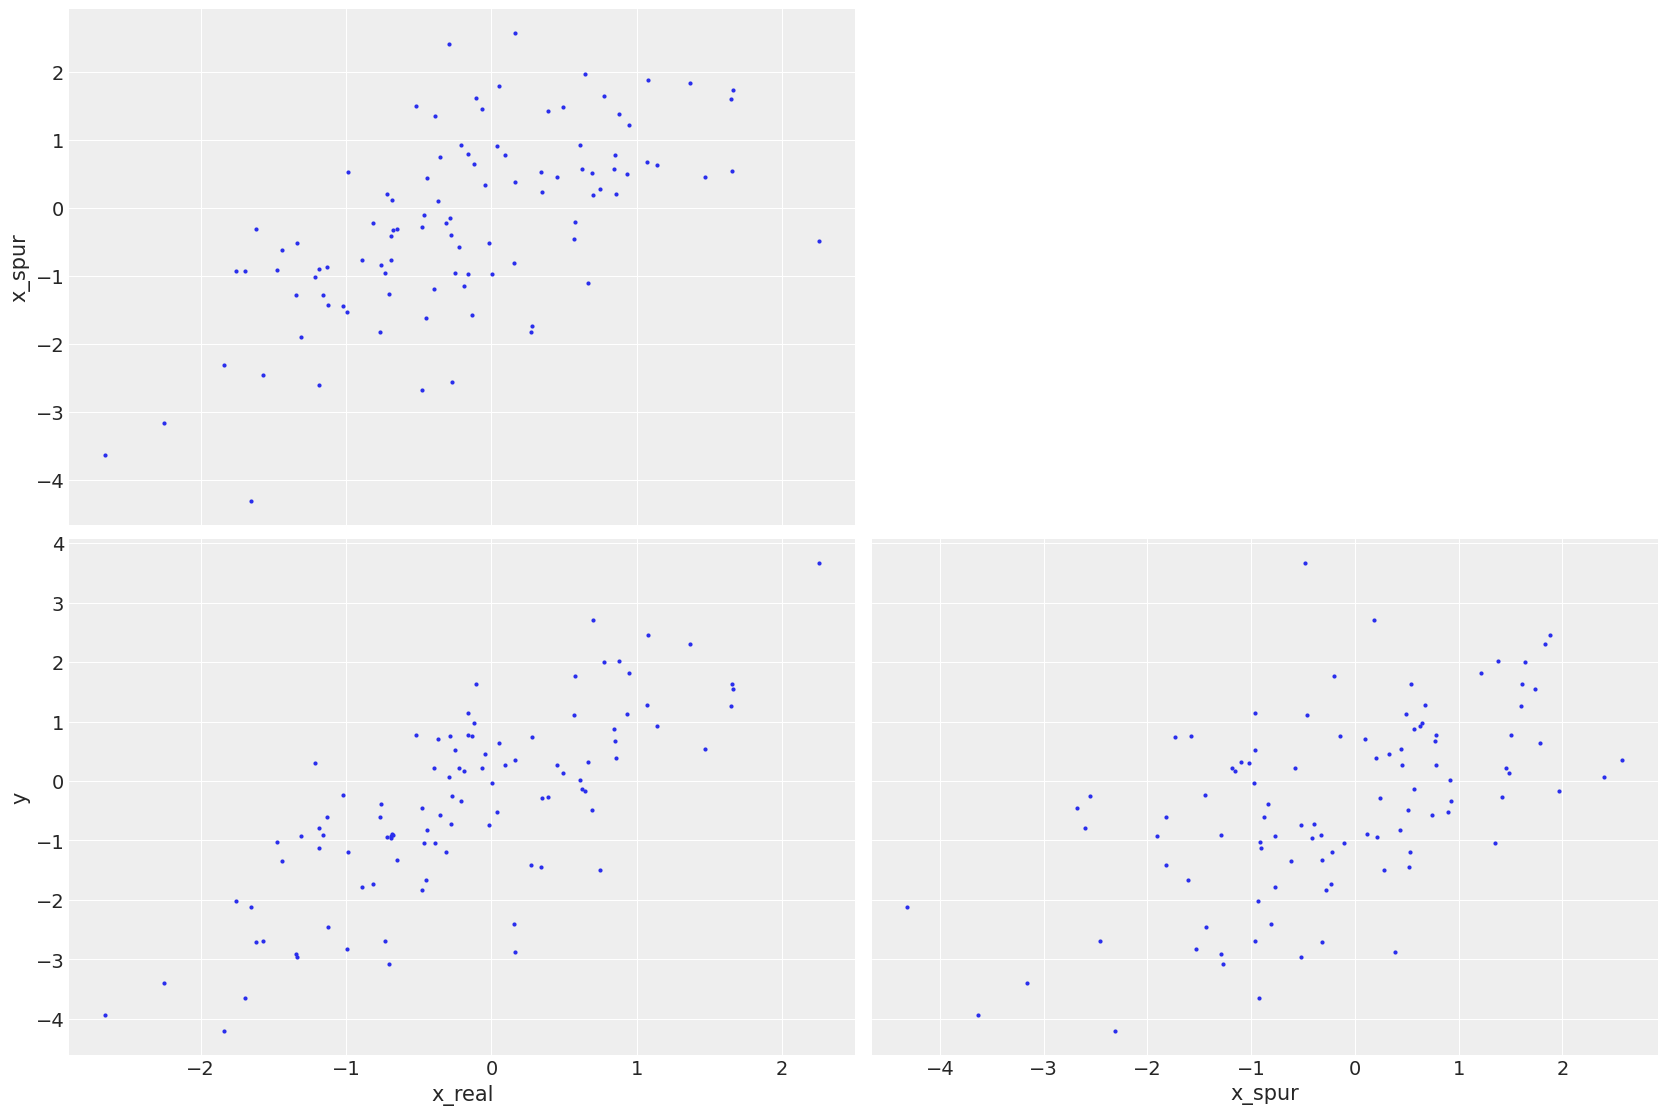

In [15]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y})

"Now the data frame d has 100 simulated cases. Because x_real influences both y and x_spur, you can think of x_spur as another outcome of x_real, but one which we mistake as a potential predictor of y. As a result, both xreal and xspur are correlated with y. You can see this in the scatterplots from pairs(d). But when you include both x variables in a linear regression predicting y, the posterior mean for the association between y and xspur will be close to zero."


## 5.1.5.3 Counterfactual Plots


### Code 5.19

In [ ]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Aesara shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal(
        "marriage", mu_M, sigma_M, observed=data["Marriage_std"].values
    )

    m5_3_A_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
